# Loading dataset

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

house = fetch_california_housing()

dataset = pd.DataFrame(house["data"])
feature_names = house["feature_names"]
dataset.columns = feature_names
dataset["label"] = house["target"]

# Quick content analysis

In [2]:
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,label
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
print(feature_names)
print("We have", len(feature_names), "features.")

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
We have 8 features.


In [4]:
print(len(dataset), "datapoints in dataset.")

20640 datapoints in dataset.


In [5]:
X = dataset[feature_names]
y = dataset["label"]

In [6]:
from matplotlib import pyplot as plt

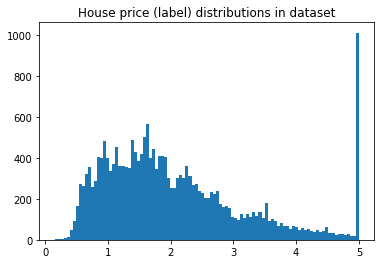

In [7]:
plt.title("House price (label) distributions in dataset")
plt.hist(y, bins=100)
plt.show()

# Shuffling, splitting, scaling, pair-plotting

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True)

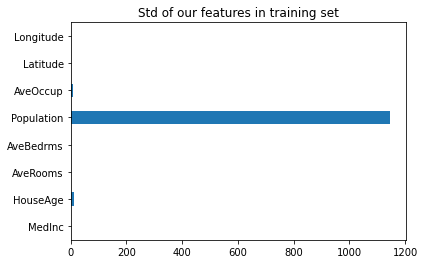

In [9]:
plt.title("Std of our features in training set")
X_train.std().plot(kind="barh")
plt.show()

We definitely need to scale our features.

In [10]:
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

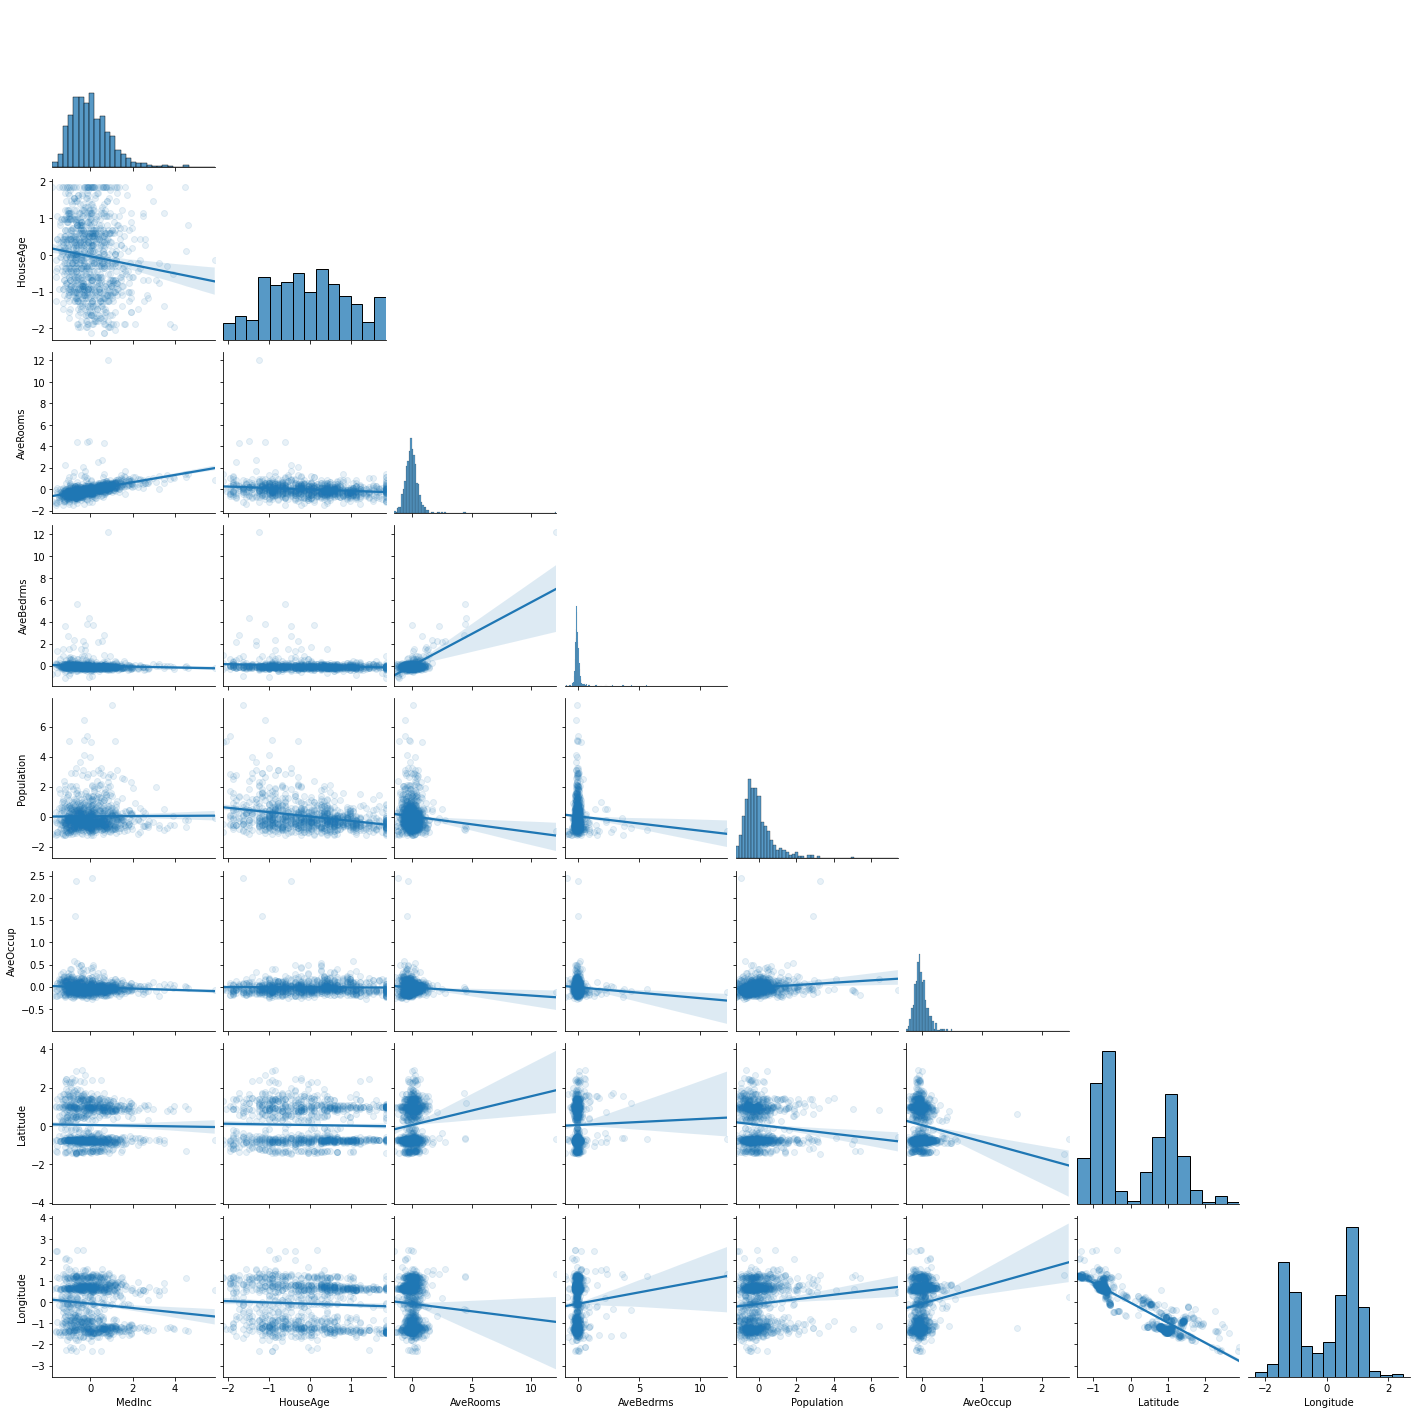

In [11]:
from seaborn import pairplot
pairplot(X_train.sample(n=1000), #, or dataset.sampel(n=1000), hue="label",
         corner=True, kind='reg', diag_kind='hist', plot_kws={'scatter_kws': {'alpha': 0.1}})

In [12]:
def get_metrics(regressor):
    pred = regressor.predict(X_train)
    train_error = ((pred - y_train) ** 2).mean()
    print("Mean train error (MSE)", train_error)

    pred = regressor.predict(X_test)
    test_error = ((pred - y_test) ** 2).mean()
    print("Mean test error (MSE)", test_error)
    
    R2 = regressor.score(X_train, y_train)
    print("R2 (train)", R2)
    R2 = regressor.score(X_test, y_test)
    print("R2 (test)", R2)

# Linear regression (OLS)

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)
get_metrics(lr)

Mean train error (MSE) 0.5192270684511334
Mean test error (MSE) 0.5404128061709079
R2 (train) 0.6109633715458154
R2 (test) 0.5911695436410489


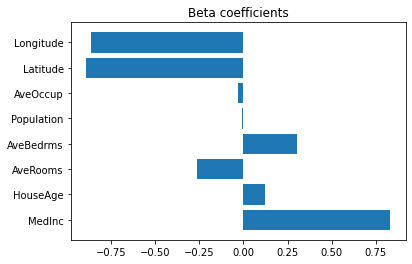

In [15]:
plt.title("Beta coefficients")
plt.barh(y=range(0, len(feature_names)), width=lr.coef_)
plt.yticks(range(0, len(feature_names)), labels=feature_names)
plt.show()

The three most important features seem to be: **Median Income in the area, Longitude, and Latitude.**

**Why is the average number of rooms coefficients negative? Does this mean that the price decreases as it goes up?**

Actually, not exactly. The coefficient quantifies the variation of the price when the given feature is varied, keeping all others constant. And we know that AveRooms is strongly correlated with AveBedrms. 

Hence, this means that for houses in the same neighborhood, etc. with the same number of bedrooms, having more rooms (non-bedrooms) decreases the price on average.

**One way to get feature importance and sensibility is to perform bootstrap (some sort of cross-validation)**

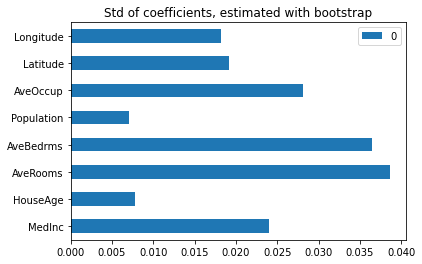

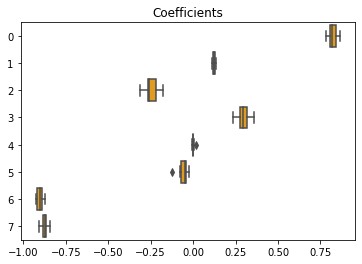

In [16]:
# BOOTSTRAP !

from sklearn.utils import resample
import numpy as np
import seaborn as sns

coeffs = []
n_iterations = 10
divider = 2 # take 50% of data for training
for i in range(n_iterations):
    X_sampled_train, y_sampled_train = resample(X, y, n_samples=len(X) // 2) # Sampling with replacement
    mean = X_sampled_train.mean()
    std = X_sampled_train.std()
    X_sampled_train = (X_sampled_train - mean) / std
    model = LinearRegression()
    model.fit(X_sampled_train, y_sampled_train)
    coeffs.append(model.coef_)
coeffs = np.array(coeffs)

coeffs_stds = np.std(coeffs, axis=0)
pd.DataFrame(coeffs_stds, index=feature_names).plot(kind="barh", 
                                                    title="Std of coefficients, estimated with bootstrap")
plt.show()


plt.title("Coefficients")
sns.boxplot(data=coeffs, orient='h', color='orange')
plt.show()

All coefficients are quite stable.

In [17]:
a = 0.95 # 95% confidence
pmin = ((1.0 - a) / 2.0) * 100 # pmin = 2.5 - Left tail threshold
pmax = (a + ((1.0 - a)/ 2.0)) * 100 # pmax = 97.5 - Right tail threshold

for i in range(len(feature_names)):
    lower = np.percentile(coeffs[:, i], pmin)
    upper = np.percentile(coeffs[:, i], pmax)
    print(f'{feature_names[i]}: confidence interval for coefficient: {lower:.2f} and {upper:.2f}')

MedInc: confidence interval for coefficient: 0.79 and 0.86
HouseAge: confidence interval for coefficient: 0.11 and 0.13
AveRooms: confidence interval for coefficient: -0.31 and -0.19
AveBedrms: confidence interval for coefficient: 0.24 and 0.35
Population: confidence interval for coefficient: -0.01 and 0.02
AveOccup: confidence interval for coefficient: -0.12 and -0.03
Latitude: confidence interval for coefficient: -0.93 and -0.87
Longitude: confidence interval for coefficient: -0.90 and -0.84


Note that the same type of confidence intervals could also be derived for the score using bootstrap.

In [18]:
print(lr.singular_)
print(lr.rank_)

[176.9096609  171.2154785  140.05289308 126.74715935 124.11118965
 101.09925824  35.08829153  26.1675547 ]
8


Finally, since no singular value is close to 0 (rank being equal to the number of features p), we expect Ridge to give similar results.

# Ridge

In [19]:
from sklearn.linear_model import Ridge

r = Ridge(alpha=1.0, solver="auto", random_state=0)
r.fit(X_train, y_train)
get_metrics(r)

Mean train error (MSE) 0.5192271707962782
Mean test error (MSE) 0.540422013844768
R2 (train) 0.6109632948625827
R2 (test) 0.5911625778965972


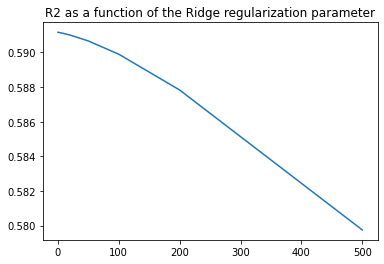

In [20]:
alphas = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500]
R2s = []
for alpha in alphas:
    r = Ridge(alpha=alpha, solver="auto", random_state=0)
    r.fit(X_train, y_train)
    R2s.append(r.score(X_test, y_test))
plt.plot(alphas, R2s)
plt.title("R2 as a function of the Ridge regularization parameter")
plt.show()

The result is fairly similar to O.L.S, and indicate that regularization is not necessary here. This probably is because we are working in a high data regime (more than 10,000 datapoints for X_train).

# Lasso

In [21]:
from sklearn.linear_model import Lasso

l = Lasso(alpha=0.01)
l.fit(X_train, y_train)
get_metrics(l)

Mean train error (MSE) 0.5247993398789748
Mean test error (MSE) 0.5476547919610523
R2 (train) 0.6067882854980373
R2 (test) 0.5856908719261646


The more we increase alpha, the more coefficients we reduce and then set to 0.

In [22]:
print(l.coef_)

[ 0.77899735  0.12866994 -0.11947817  0.16185196 -0.         -0.02249573
 -0.78776977 -0.75275992]


# Regression Tree

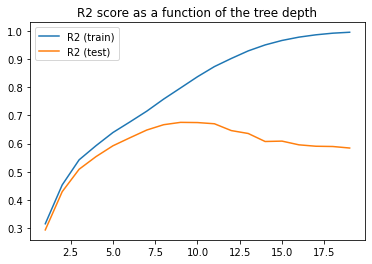

In [23]:
from sklearn.tree import DecisionTreeRegressor

depths = range(1, 20)
R2s_train = []
R2s_test = []
for depth in depths:
    t = DecisionTreeRegressor(max_depth=depth)
    t.fit(X_train, y_train)
    R2s_train.append(t.score(X_train, y_train))
    R2s_test.append(t.score(X_test, y_test))

plt.title("R2 score as a function of the tree depth")
plt.plot(depths, R2s_train, label="R2 (train)")
plt.plot(depths, R2s_test, label="R2 (test)")
plt.legend()
plt.show()

In [24]:
t = DecisionTreeRegressor(max_depth=9)
t.fit(X_train, y_train)
get_metrics(t)

Mean train error (MSE) 0.2706485738136834
Mean test error (MSE) 0.4288424034406019
R2 (train) 0.7972135602126869
R2 (test) 0.6755742397243565


Interestingly, we notice as expected that the deeper our tree, the more we can split our training data precisely (causing overfitting). The optimal depth for this usecase seems to be around 10.


Other parameters can play, such as minimum number of elements in leaves, type of solver, splitting criterion, etc.


If the tree size is chosen appropriately, **we can get an R2 on test of up to 0.68, beating linear methods.** This indicates that this problem is probably non-linear.

# Random Forest Regressor

Random forest is basically an ensembling of trees, selecting random features for each tree. 

We use the depth determined in the previous section (Regression Tree).

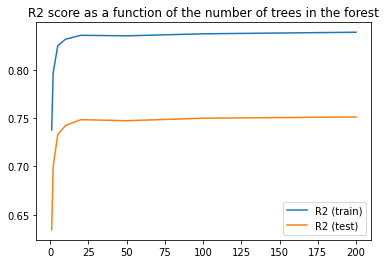

In [25]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = [1, 2, 5, 10, 20, 50, 100, 200]
R2s_train = []
R2s_test = []
for n in n_estimators:
    f = RandomForestRegressor(n_estimators=n, max_depth=9)
    f.fit(X_train, y_train)
    R2s_train.append(f.score(X_train, y_train))
    R2s_test.append(f.score(X_test, y_test))

plt.title("R2 score as a function of the number of trees in the forest")
plt.plot(n_estimators, R2s_train, label="R2 (train)")
plt.plot(n_estimators, R2s_test, label="R2 (test)")
plt.legend()
plt.show()

After around 100 estimators, we see that the performance does not increase anymore. 

We also notice that the **R2 of 0.75 on test is better than everything we had before, notably a single tree. This means boosting / ensembling is efficient!**

In [26]:
f = RandomForestRegressor(n_estimators=100, max_depth=9, random_state=0)
f.fit(X_train, y_train)
get_metrics(f)

Mean train error (MSE) 0.21559002502064217
Mean test error (MSE) 0.32984906052400054
R2 (train) 0.8384667873487849
R2 (test) 0.7504641999528212


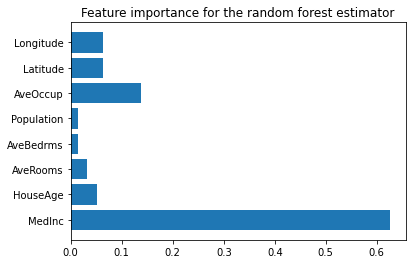

In [27]:
plt.title("Feature importance for the random forest estimator")
plt.barh(y=range(0,8), width=f.feature_importances_)
plt.yticks(range(0,8), labels=feature_names)
plt.show()

We could also compute feature importance for the Random Forest by permutation (we won't do that here).

# Multi-layer perceptron (MLP)

/Users/antoine/.pyenv/versions/3.7.3/envs/sensei/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/antoine/.pyenv/versions/3.7.3/envs/sensei/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/antoine/.pyenv/versions/3.7.3/envs/sensei/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


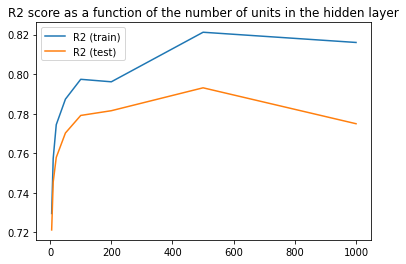

In [28]:
from sklearn.neural_network import MLPRegressor

hidden_layer_size = [5, 10, 20, 50, 100, 200, 500, 1000]
R2s_train = []
R2s_test = []
for s in hidden_layer_size:
    mlp = MLPRegressor(hidden_layer_sizes=(s,), max_iter=200, random_state=0)
    mlp.fit(X_train, y_train)
    R2s_train.append(mlp.score(X_train, y_train))
    R2s_test.append(mlp.score(X_test, y_test))
    
plt.title("R2 score as a function of the number of units in the hidden layer")
plt.plot(hidden_layer_size, R2s_train, label="R2 (train)")
plt.plot(hidden_layer_size, R2s_test, label="R2 (test)")
plt.legend()
plt.show()

In [29]:
mlp = MLPRegressor(hidden_layer_sizes=(500), max_iter=200, random_state=0)
mlp.fit(X_train, y_train)
get_metrics(mlp)

Mean train error (MSE) 0.23861632072915578
Mean test error (MSE) 0.2734787605652598
R2 (train) 0.8212140804070006
R2 (test) 0.7931091839244531


The little non-linear black box beats everything here (R2 on test of almost 0.79), which clearly shows that **this problem is a non-linear one.**

The limit of using MLP in scikit learn is that it is difficult to see the learning curves properly (Keras / Tensorflow comes more handy for such estimators).

The main drawbacks of using neural networks are their limited interpretability, as well as the tuning of all of their training hyper-parameters. Here for example, using a second hidden layer of 500 units will start causing over-fitting (R2 on train becomes 0.93, R2 on test decreases to 0.777).

# Conclusions

- **Scaling of the features is crucial** to compare coefficients and to perform Ridge / PCA / ...
- **Bootstrap cross-validation** allows to compute std and confidence intervals for coefficients and score
- All these elements can give a relevant **comparison of the features** and their relative importance
- Correlation between features can cause degeneration and instability of some coefficients (high std, low confidence)


- In this usecase, Ridge and Lasso do not improve the base OLS model, because:
    - 1. We already are in high-data regime (the covariance matrix is already invertible, we do not need regularization)
    - 2. The performance saturates anyway because the **features of interest do not predict the price in a linear fashion**
- For these linear regression methods, R2 score is quite low and test error is relatively high (compared to std of target distribution, for example)
- **Tree, Random Forest, and MLP perform much better as they treat the data in a non-linear fashion**

# To do left

- This ressource was quite helpful:
    - https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

- Dealing with dummy variables: 
    - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
- Boosting (Bagging, Adaboost, Gradient Boosting, ...)